In [1]:
import os
os.chdir('../')
from python_code import gibbs_sampler as gs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.style as style
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
from itertools import combinations
import pymc3 as pm

In [2]:
df = pd.read_csv('../data/mathtest.csv')
df.columns = ['group', 'values']

In [3]:
gibbs = gs.GibbsSampler(df, n_iter=5000, burn=100)

In [4]:
gibbs.fit()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 802.78it/s]


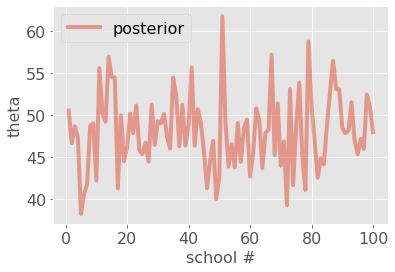

In [5]:
group = df.groupby('group')
plt.plot(np.unique(df['group']),gibbs.traces['theta'].mean(axis=0),alpha=.5, label='posterior')
plt.legend()
plt.xlabel('school #', fontsize=16)
plt.ylabel('theta', fontsize=16);

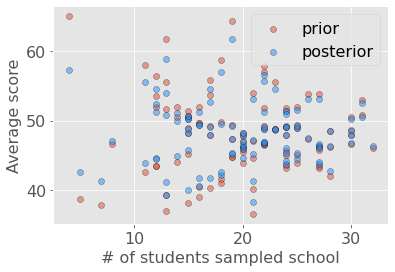

In [6]:
plt.scatter(group.size(), group.mean(), alpha=.5, edgecolor='black', label='prior');
plt.scatter(group.size(), gibbs.traces['theta'].mean(axis=0), color='dodgerblue', alpha=.5, edgecolor='black', label='posterior');
plt.xlabel('# of students sampled school', fontsize=16)
plt.legend()
plt.ylabel('Average score', fontsize=16);

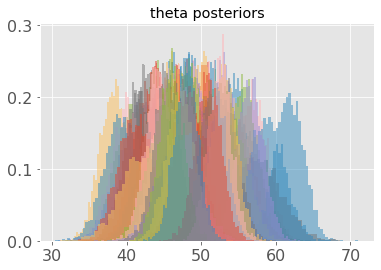

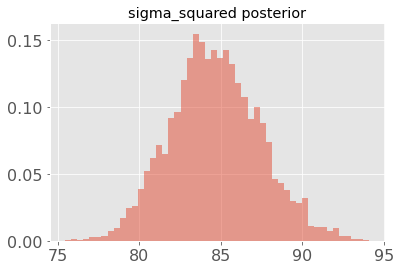

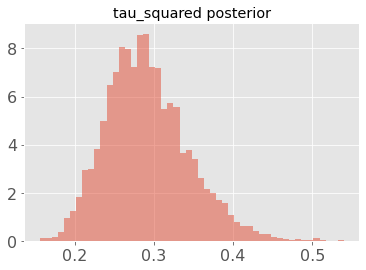

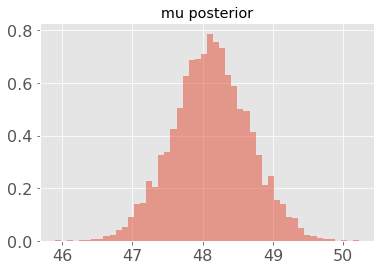

<Figure size 432x288 with 0 Axes>

In [7]:
gibbs.plot_all_posteriors();

In [8]:
group_means = group.mean().to_numpy().flatten()
k_i = np.abs(( gibbs.traces['theta'] - group_means)/group_means).mean(axis=0)

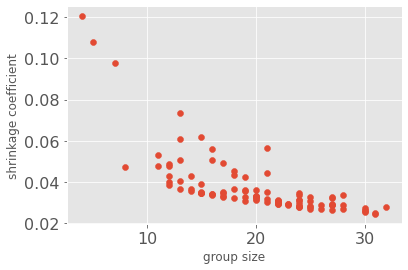

In [9]:
plt.scatter(group.size(), k_i)
plt.xlabel('group size')
plt.ylabel('shrinkage coefficient');

In [10]:
mu = gibbs.traces['mu'].mean()
cov_schools = np.zeros(gibbs.P)
for school in range(gibbs.P):
    all_idx = list(range(gibbs.n_i[school]))
    combs = list(combinations(all_idx, 2))
    combs_not_identical = [comb for comb in combs if combs[0] != combs[1]]
    rows = df[df['group'] == school + 1].reset_index()['values']
    terms = []
    for comb in combs_not_identical:
        terms.append((rows.iloc[comb[0]]-mu) * (rows.iloc[comb[1]]-mu))
    cov_schools[school] = np.mean(terms)

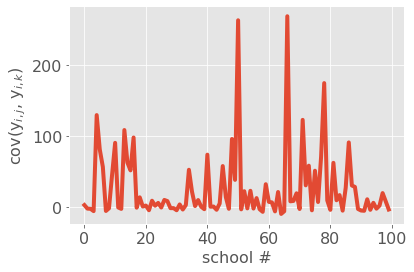

In [11]:
plt.plot(cov_schools)
plt.xlabel('school #', fontsize=16)
plt.ylabel('cov(y$_{i,j}$, y$_{i,k}$)', fontsize=16);

In [12]:
all_idx = list(range(gibbs.P))
combs = list(combinations(all_idx, 2))
combs_not_identical = [comb for comb in combs if combs[0] != combs[1]]
terms = []
for comb in combs_not_identical:
    terms.append((cov_schools[comb[0]] - mu)*(cov_schools[comb[0]] - mu))
cov = np.mean(terms)

In [13]:
cov

2733.428587050872

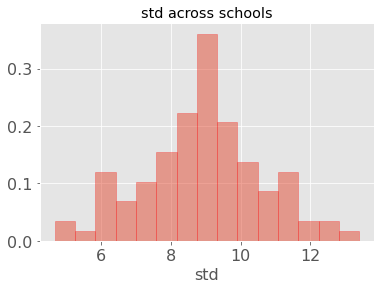

In [14]:
plt.hist(group.std(), alpha=0.5, edgecolor='red', bins=15, density=True);
plt.title('std across schools');
plt.xlabel('std', fontsize=16);

### try with pymc

In [120]:
theta_means = []
from tqdm import tqdm
for school in tqdm(range(gibbs.P)):
    data = df[df['group'] == school+1]
    traces = {'sigma': np.zeros(2000),
                       'tau': np.zeros(2000),
                       'mu': np.zeros(2000),
                       'theta': np.zeros(2000)}
    
    with pm.Model() as model:
        sigma = pm.Normal('sigma',mu=1e-6, sigma=1e3)
        mu = pm.Normal('mu',mu=1e-6, sigma=1e3)
        tau = pm.InverseGamma('tau',0.5,0.5)
        theta = pm.Normal('theta', mu=mu, sd = tau*sigma)
        y = pm.Normal('y', mu=theta, sd=sigma, observed=data['values'])
        try:
            trace = pm.sample(2000, tune = 1000, chains=2,cores=1, return_inferencedata=False)
            theta_means.append(trace.get_values('theta').mean())
        except:
             theta_means.append(None)
             


  0%|                                                                                                                                                                                                   | 0/100 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 732 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.498312118085991, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1092 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6905942127255487, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
  1%|█▊                                                                                                                                                                                         | 1/100 [00:05<09:12,  5.58s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 508 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6348661954071729, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1041 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5774193659634144, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
  2%|███▋                                                                                                                                                                                       | 2/100 [00:11<09:07,  5.58s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 487 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6152250517891141, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1532 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.34030408724550587, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
  3%|█████▌                                                                                                                                                                                     | 3/100 [00:17<09:18,  5.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 875 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3853882350442604, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1207 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
  4%|███████▍                                                                                                                                                                                   | 4/100 [00:23<09:24,  5.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 284 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1016 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49590389780185046, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
  5%|█████████▎                                                                                                                                                                                 | 5/100 [00:28<09:12,  5.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 432 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6414530542088541, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1051 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5252499156091656, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
  6%|███████████▏                                                                                                                                                                               | 6/100 [00:35<09:21,  5.98s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 621 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5254056691897449, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1292 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5378747288069596, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
  7%|█████████████                                                                                                                                                                              | 7/100 [00:41<09:21,  6.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.
There were 713 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.674062137396953, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
  8%|██████████████▉                                                                                                                                                                            | 8/100 [00:47<09:22,  6.12s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 351 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6710099375529244, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1442 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.36612215550909954, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
  9%|████████████████▊                                                                                                                                                                          | 9/100 [00:53<09:08,  6.03s/it]Auto-assigning NUTS sampler...
Initializing NUTS using 

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 762 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47834320350958703, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1260 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6378346203925201, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 10%|██████████████████▌                                                                                                                                                                       | 10/100 [00:58<08:48,  5.87s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 791 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46644388624149274, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2791 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 2.969987920473955e-36, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 11%|████████████████████▍                                                                                                                                                                     | 11/100 [01:04<08:22,  5.64s/it]Auto-assigning NUTS sa

/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
 12%|██████████████████████▎                                                                                                                                                                   | 12/100 [01:05<06:30,  4.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 242 divergences after tuning. Increase `target_accept` or reparameterize.
There were 413 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
 13%|████████████████████████▏                                                                                                                                                                 | 13/100 [01:11<07:05,  4.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 298 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1215 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3794731195095903, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 14%|██████████████████████████                                                                                                                                                                | 14/100 [01:17<07:18,  5.09s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 496 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5258770337759096, but should be close to 0.8. Try to increase the number of tuning steps.
There were 685 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
 15%|███████████████████████████▉                                                                                                                                                              | 15/100 [01:22<07:27,  5.26s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 658 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48003585304567914, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1608 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3993786258274833, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 16%|█████████████████████████████▊                                                                                                                                                            | 16/100 [01:28<07:36,  5.44s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 1062 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33229477813319114, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1174 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 17%|███████████████████████████████▌                                                                                                                                                          | 17/100 [01:34<07:33,  5.47s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 350 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6910438266779843, but should be close to 0.8. Try to increase the number of tuning steps.
There were 599 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
 18%|█████████████████████████████████▍                                                                                                                                                        | 18/100 [01:40<07:45,  5.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 266 divergences after tuning. Increase `target_accept` or reparameterize.
There were 370 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
 19%|███████████████████████████████████▎                                                                                                                                                      | 19/100 [01:47<08:08,  6.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 708 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5139438355664213, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1294 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5379774922993179, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 20%|█████████████████████████████████████▏                                                                                                                                                    | 20/100 [01:53<08:01,  6.02s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 431 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6551523086857057, but should be close to 0.8. Try to increase the number of tuning steps.
There were 942 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5809560066606634, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 21%|███████████████████████████████████████                                                                                                                                                   | 21/100 [01:58<07:41,  5.84s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 927 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4008129357059601, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1321 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6804072231464035, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 22%|████████████████████████████████████████▉                                                                                                                                                 | 22/100 [02:03<07:17,  5.60s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 241 divergences after tuning. Increase `target_accept` or reparameterize.
There were 667 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6480065866086909, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 23%|██████████████████████████████████████████▊                                                                                                                                               | 23/100 [02:09<07:16,  5.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 591 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6119126270546575, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1085 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.609542077852542, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 24%|████████████████████████████████████████████▋                                                                                                                                             | 24/100 [02:15<07:06,  5.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
There were 428 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7088454884158056, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1037 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5341616036036985, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 25%|██████████████████████████████████████████████▌                                                                                                                                           | 25/100 [02:21<07:14,  5.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 708 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4852736719796339, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1293 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5895023024658831, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 26%|████████████████████████████████████████████████▎                                                                                                                                         | 26/100 [02:26<06:53,  5.58s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 287 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7149549166736834, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1129 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4104900225573484, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 27%|██████████████████████████████████████████████████▏                                                                                                                                       | 27/100 [02:31<06:43,  5.53s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 501 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5790549666164386, but should be close to 0.8. Try to increase the number of tuning steps.
There were 955 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5867325087810636, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 28%|████████████████████████████████████████████████████                                                                                                                                      | 28/100 [02:37<06:39,  5.55s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 464 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6817090318798055, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1091 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.559571099764928, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 29%|█████████████████████████████████████████████████████▉                                                                                                                                    | 29/100 [02:44<06:56,  5.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 671 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5264899620952266, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1150 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6455481837390613, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 30%|███████████████████████████████████████████████████████▊                                                                                                                                  | 30/100 [02:50<06:53,  5.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 548 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5844664323493183, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1102 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5865425772113008, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 31%|█████████████████████████████████████████████████████████▋                                                                                                                                | 31/100 [02:56<06:49,  5.93s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 621 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5135870513823445, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6302393093972932, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 32%|███████████████████████████████████████████████████████████▌                                                                                                                              | 32/100 [03:01<06:32,  5.77s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 244 divergences after tuning. Increase `target_accept` or reparameterize.
There were 703 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6426202909200252, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 33%|█████████████████████████████████████████████████████████████▍                                                                                                                            | 33/100 [03:08<06:44,  6.03s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
 34%|███████████████████████████████████████████████████████████████▏                                                                                                                          | 34/100 [03:11<05:50,  5.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 351 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6939645077790426, but should be close to 0.8. Try to increase the number of tuning steps.
There were 801 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6461573201594099, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 35%|█████████████████████████████████████████████████████████████████                                                                                                                         | 35/100 [03:17<05:50,  5.39s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
There were 322 divergences after tuning. Increase `target_accept` or reparameterize.
There were 647 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6840998718661251, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 36%|██████████████████████████████████████████████████████████████████▉                                                                                                                       | 36/100 [03:23<06:03,  5.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 715 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47791409030932686, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1740 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33058198519654347, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 37%|████████████████████████████████████████████████████████████████████▊                                                                                                                     | 37/100 [03:29<05:58,  5.68s/it]Auto-

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1340 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.16757840478050437, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1920 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6091713182278881, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 38%|██████████████████████████████████████████████████████████████████████▋                                                                                                                   | 38/100 [03:34<05:35,  5.42s/it]Auto-assigning NUTS samp

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 825 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4209594317811218, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1210 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6471522563597557, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 39%|████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 39/100 [03:39<05:34,  5.48s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)

/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
 40%|██████████████████████████████████████████████████████████████████████████▍                                                                                                               | 40/100 [03:41<04:27,  4.47s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 937 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.42189327008253497, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1668 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4777002565618872, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 41%|████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 41/100 [03:46<04:33,  4.64s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 443 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.633268666771027, but should be close to 0.8. Try to increase the number of tuning steps.
There were 835 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6806916739921149, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 42/100 [03:52<04:52,  5.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jit

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
There were 431 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6556443426308961, but should be close to 0.8. Try to increase the number of tuning steps.
There were 455 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9461357278951048, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 43%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 43/100 [03:59<05:15,  5.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 776 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4361860809818847, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1028 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 44%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 44/100 [04:04<05:08,  5.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 771 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4801212696108221, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1773 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.36473007850022127, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 45%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 45/100 [04:10<05:02,  5.50s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 863 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4408640932344184, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1138 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 46%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 46/100 [04:16<05:00,  5.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 999 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4198980560013638, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1673 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4658808945066808, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 47%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 47/100 [04:21<04:51,  5.51s/it]Auto-assigning NUTS sample

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 810 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4891342900244804, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1849 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.35447450017356424, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 48%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 48/100 [04:27<04:50,  5.59s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 530 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5933249458316698, but should be close to 0.8. Try to increase the number of tuning steps.
There were 756 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
 49%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 49/100 [04:33<05:00,  5.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 514 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6071731947386959, but should be close to 0.8. Try to increase the number of tuning steps.
There were 921 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6691927345992729, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 50/100 [04:39<04:49,  5.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using ji

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 360 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6437441628133062, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1239 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43688383138932657, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 51/100 [04:45<04:41,  5.74s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 902 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3713133183163016, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1641 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4781276096399373, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 52/100 [04:50<04:30,  5.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 452 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6447554795960225, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1473 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3617222721414807, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 53/100 [04:55<04:13,  5.39s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 246 divergences after tuning. Increase `target_accept` or reparameterize.
There were 521 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 54/100 [05:01<04:20,  5.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 593 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6197797378198822, but should be close to 0.8. Try to increase the number of tuning steps.
There were 956 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6684840421616232, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 55/100 [05:06<04:10,  5.57s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 334 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1140 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.448504421873972, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 56/100 [05:12<04:03,  5.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 608 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5704790717381807, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1266 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5425791841237939, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 57/100 [05:17<03:55,  5.48s/it]Auto-as

/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 58/100 [05:21<03:27,  4.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1095 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.32760160934982274, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2039 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4310884738110917, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 59/100 [05:26<03:18,  4.83s/it]Auto-

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 584 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6303223517315644, but should be close to 0.8. Try to increase the number of tuning steps.
There were 955 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6935815728068775, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 60/100 [05:31<03:23,  5.08s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 912 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4016024557172509, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2500 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.13465048713594577, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 61/100 [05:36<03:15,  5.01s/it]Auto-assigning NUTS sampl

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 600 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.528102559278532, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1126 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6118728943798785, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 62/100 [05:42<03:16,  5.17s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 699 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4892720464007618, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1215 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6204621009201662, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 63/100 [05:47<03:15,  5.29s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 594 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5846281943781146, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1150 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5647607792344568, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 64/100 [05:53<03:14,  5.41s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1506 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.16527344532842417, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2444 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.400156682479157, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 65/100 [05:58<03:04,  5.28s/it]Auto-assigning NUTS sampl

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 449 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6146683352275975, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1301 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.36369578189995194, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 66/100 [06:04<03:08,  5.56s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
There were 344 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6854064318092123, but should be close to 0.8. Try to increase the number of tuning steps.
There were 519 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 67/100 [06:11<03:15,  5.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 843 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.41250263001639437, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1334 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5920188528080721, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 68/100 [06:16<03:04,  5.76s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1085 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2922337856411002, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1691 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5291755670639556, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 69/100 [06:21<02:51,  5.52s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 847 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4364701303822701, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1332 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6831271509067129, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 70/100 [06:27<02:47,  5.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using j

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 764 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44365540063981285, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1437 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47658994748095257, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 71/100 [06:32<02:38,  5.47s/it]Auto-

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 1305 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2796428365715593, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.41515673166675876, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 72/100 [06:38<02:33,  5.49s/it]Auto-assigning NUTS sampler...
Initializing NUTS using

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 506 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5841928669095827, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1261 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47091045171431356, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 73/100 [06:43<02:25,  5.38s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
There were 770 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5464987459446531, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 74/100 [06:49<02:25,  5.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
There were 603 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6892179531797217, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 75/100 [06:55<02:26,  5.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 1403 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.23090188363135067, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1761 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 76/100 [07:01<02:20,  5.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 703 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45139511134632926, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1194 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6158772008230627, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 77/100 [07:07<02:14,  5.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using 

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1583 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.15726460138426332, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2177 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5724097768211764, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 78/100 [07:12<02:02,  5.57s/it]Auto-assigning NUTS samp

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 811 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4870039104238493, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1506 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4910078258397751, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 79/100 [07:17<01:54,  5.43s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 482 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6113007156812241, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1061 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.590678016941209, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 80/100 [07:22<01:47,  5.40s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 427 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6572929089954378, but should be close to 0.8. Try to increase the number of tuning steps.
There were 674 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 81/100 [07:28<01:45,  5.57s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 784 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3914824142716349, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1122 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6596986425273694, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 82/100 [07:35<01:46,  5.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 308 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6832305348763652, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1020 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47822101490580926, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 83/100 [07:41<01:38,  5.82s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1053 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.32970999814242546, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1598 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6279792965197691, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 84/100 [07:46<01:32,  5.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 1291 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.25701419318904406, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1753 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6310314780403306, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 85/100 [07:52<01:24,  5.63s/it]Auto-

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 368 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6943465260064273, but should be close to 0.8. Try to increase the number of tuning steps.
There were 787 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6557327425653159, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 86/100 [07:57<01:19,  5.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1770 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.04621905719326712, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2451 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48022812599914744, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 87/100 [08:02<01:09,  5.35s/it]Auto-assigning NUTS sam

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
There were 525 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5630003237856069, but should be close to 0.8. Try to increase the number of tuning steps.
There were 546 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9435032292362372, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 88/100 [08:09<01:09,  5.81s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 621 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5660331061192763, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1008 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6868784916095819, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 89/100 [08:15<01:03,  5.79s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 400 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7059762287754001, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.513083624087062, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 90/100 [08:20<00:57,  5.78s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1545 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.10397382097649988, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2262 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5047689340975242, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 91/100 [08:25<00:49,  5.52s/it]Auto-assigning NUTS samp

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 815 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46689192137190527, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1209 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7050834193200778, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 92/100 [08:31<00:44,  5.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using 

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 729 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5006053501229156, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1075 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 93/100 [08:36<00:38,  5.47s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1539 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.14118215585328647, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2649 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.32543196630711907, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 94/100 [08:41<00:32,  5.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS usin

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 649 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5632730101346612, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1557 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4463505964399459, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 95/100 [08:46<00:26,  5.32s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 606 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5849131897014418, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1980 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1624966465831875, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 96/100 [08:51<00:20,  5.24s/it]Auto-assigning NUTS sample

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 474 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5942894137584758, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1217 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4973637009481985, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 97/100 [08:57<00:15,  5.30s/it]Auto-assigning NUTS sampler...
Initializing NUTS using j

/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 98/100 [08:59<00:08,  4.32s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 883 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43863485794303325, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1659 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48000304531602594, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 99/100 [09:04<00:04,  4.63s/it]Auto-

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 437 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7088503197001598, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1177 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45570687997888665, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:10<00:00,  5.50s/it]


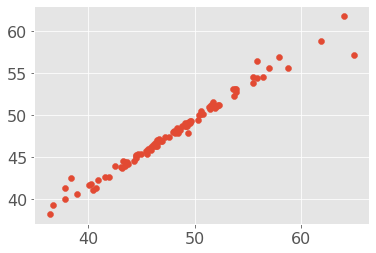

In [121]:
gibbs_means = gibbs.traces['theta'].mean(axis=0)
plt.scatter(theta_means, gibbs_means)

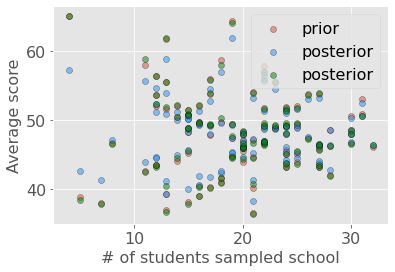

In [122]:
plt.scatter(group.size(), group.mean(), alpha=.5, edgecolor='black', label='prior');
plt.scatter(group.size(), gibbs.traces['theta'].mean(axis=0), color='dodgerblue', alpha=.5, edgecolor='black', label='posterior');
plt.scatter(group.size(), theta_means, color='green', alpha=.5, edgecolor='black', label='posterior');

plt.xlabel('# of students sampled school', fontsize=16)
plt.legend()
plt.ylabel('Average score', fontsize=16);